## Multiple Linear Regression and Regularization with Admissions Dataset

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
admissions = pd.read_csv('admission.csv')
admissions.head()

,gre_score,toefl_score,univ_ranking,motiv_letter_strength,recommendation_strength,gpa,research_exp,admission_score
0,337,118,4,4.5,4.5,9.65,1,92
1,324,107,4,4.0,4.5,8.87,1,76
2,316,104,3,3.0,3.5,8.00,1,72
3,322,110,3,3.5,2.5,8.67,1,80
4,314,103,2,2.0,3.0,8.21,0,65


# **EDA**

In [4]:
df = admissions.copy()
df.shape

(500, 8)

In [ ]:
#feature engineering

# **Feature Engineering**

# **Data Preprocessing**

### Split Data

In [4]:
from sklearn.model_selection import train_test_split

X = admissions.drop(columns='admission_score')
y = admissions['admission_score']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.20,
                                                    random_state=42)

In [5]:
x = df.copy()
y = x.pop("admission_score")

In [7]:
print(f"x shape: {x.shape} | y shape: {y.shape}")

x shape: (500, 7) | y shape: (500,)


c:\Users\Ignatius Lanang\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='admission_score', ylabel='Count'>

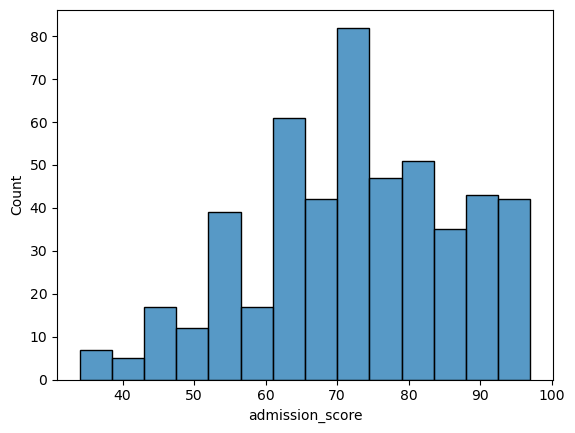

In [8]:
sns.histplot(y)

c:\Users\Ignatius Lanang\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='admission_score', ylabel='Count'>

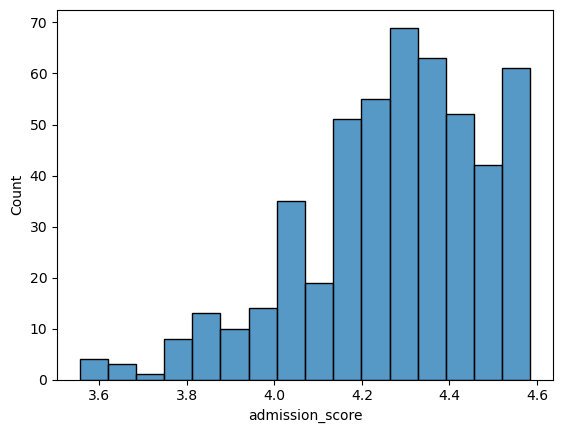

In [11]:
y = np.log1p(y)
sns.histplot(a)

In [16]:
x.head()

,gre_score,toefl_score,univ_ranking,motiv_letter_strength,recommendation_strength,gpa,research_exp
0,337,118,4,4.5,4.5,9.65,1
1,324,107,4,4.0,4.5,8.87,1
2,316,104,3,3.0,3.5,8.00,1
3,322,110,3,3.5,2.5,8.67,1
4,314,103,2,2.0,3.0,8.21,0


In [15]:
y.shape

(500,)

In [27]:
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

cv = RepeatedKFold(n_repeats=3, n_splits=5)
y_preds = np.zeros(x.shape[0])
y_val_acc = []
for fold, (trn_idx, val_idx) in enumerate(cv.split(x,y)):
    x_train, y_train = x.iloc[trn_idx], y.iloc[trn_idx]
    x_val, y_val = x.iloc[val_idx], y.iloc[val_idx]

    model = LinearRegression(n_jobs=10)
    model.fit(x_train, y_train)

    preds = model.predict(x_val)
    trn_preds = model.predict(x_train) 
    y_preds[val_idx] = preds
    y_rmse = np.sqrt(mean_squared_error(y_val, preds))
    trn_rmse = np.sqrt(mean_squared_error(y_train, trn_preds))

    y_val_acc.append(y_rmse)
    print(f"fold {fold} y_preds rmse {y_rmse}")
print(f"rmse mean {np.mean(y_val_acc)}")

fold 0 y_preds rmse 0.11453861673922215
fold 1 y_preds rmse 0.10369957173864892
fold 2 y_preds rmse 0.11333031265422142
fold 3 y_preds rmse 0.08898499738080637
fold 4 y_preds rmse 0.08936522928268781
fold 5 y_preds rmse 0.1009575692237949
fold 6 y_preds rmse 0.11147545859777729
fold 7 y_preds rmse 0.08748912093389402
fold 8 y_preds rmse 0.10827819698173417
fold 9 y_preds rmse 0.1031544121285464
fold 10 y_preds rmse 0.1170401397475314
fold 11 y_preds rmse 0.09523828105151863
fold 12 y_preds rmse 0.09142788527865243
fold 13 y_preds rmse 0.1006704703289837
fold 14 y_preds rmse 0.10322828469665613
rmse mean 0.1019252364509784


In [33]:
y_inverse = np.expm1(y_preds)
result = pd.DataFrame(data={'preds': y_inverse})
result['y_true'] = df['admission_score']
result['preds'] = result['preds'].astype(int)
result

,preds,y_true
0,98,92
1,79,76
2,63,72
3,72,80
4,62,65
...,...,...
495,82,87
496,104,96
497,97,93
498,68,73


In [ ]:
y true 100 preds 99 
100 preds 95

### Multicollinearity Handling

In [5]:
# calculating VIF scores for each column in X_train
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.tools.tools import add_constant

X = add_constant(X_train)

vif_df = (pd.DataFrame(
            [vif(X.values, i) for i in range(len(X.columns))]
            ,index=X.columns)
            .reset_index())

vif_df.columns = ['feature', 'vif_score']
vif_df = vif_df.loc[vif_df.feature!='const']
vif_df

,feature,vif_score
1,gre_score,4.489983
2,toefl_score,3.664298
3,univ_ranking,2.572110
4,motiv_letter_strength,2.785764
5,recommendation_strength,1.977698
6,gpa,4.654540
7,research_exp,1.518065


There are 2 features with a vif score > 4,
- gre_score
- gpa

Therefore, we would like to proceed with correlation analysis

### Correlation Analysis

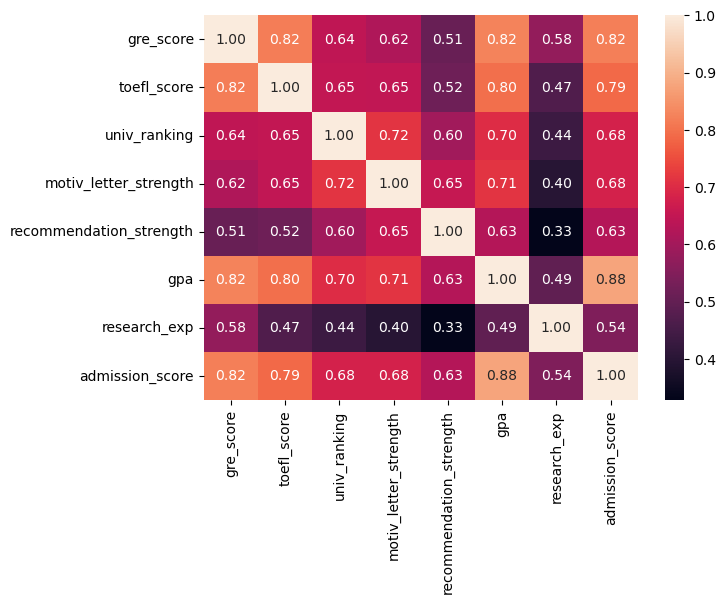

In [6]:
# heatmap correlation
admit_train = pd.concat([X_train, y_train], axis=1)
corr = admit_train.corr()

plt.figure(figsize=(7,5))
sns.heatmap(corr, annot=True, fmt='.2f')
plt.show()

Based on our correlation analysis, we want to drop:
- gre_score
- toefl_score

This is because we have 3 features with high correlation to our target variable, that is "admission_score". Among these 3 features, the feature that has a higher correlation to the target variable is "gpa".

In [7]:
# drop redundant features
X_train = X_train.drop(columns=['gre_score', 'toefl_score'])
X_test  = X_test.drop(columns=['gre_score', 'toefl_score'])

In [8]:
# rechecking VIF scores
X = add_constant(X_train)

vif_df = (pd.DataFrame(
            [vif(X.values, i) for i in range(len(X.columns))]
            ,index=X.columns)
            .reset_index())

vif_df.columns = ['feature', 'vif_score']
vif_df = vif_df.loc[vif_df.feature!='const']
vif_df

,feature,vif_score
1,univ_ranking,2.511407
2,motiv_letter_strength,2.748278
3,recommendation_strength,1.965542
4,gpa,2.726281
5,research_exp,1.350514


### Model Training

In [9]:
# tranform to numpy arrays
X_admit_train = X_train.to_numpy()
y_admit_train = y_train.to_numpy().ravel()

In [10]:
# model training
from sklearn.linear_model import LinearRegression

# define the model
multi_reg = LinearRegression()

# train
multi_reg.fit(X_train, y_train)

LinearRegression()

In [11]:
# retrieve the coefficients

data = X_train
model = multi_reg

coef_df = pd.DataFrame({
    'feature':['intercept'] + data.columns.tolist(),
    'coefficient':[model.intercept_] + list(model.coef_)
})

coef_df

,feature,coefficient
0,intercept,-77.095602
1,univ_ranking,0.710105
2,motiv_letter_strength,0.459470
3,recommendation_strength,1.455866
4,gpa,16.144274
5,research_exp,3.821250


admission_score = -77.09 + 0.71 univ_ranking + 0.45 motiv_letter + 1.45 reco_strength + 16.14 gpa + 3.82 research_exp



Interpretation of the coefficients:
- An increase of 1 GPA point, assuming all other features remain constant, is associated with an increase of 16.14 points in the admission_score.

### Model Evaluation

In [12]:
# prepare the array of the precidtion model result

# training data
y_pred_train = multi_reg.predict(X_admit_train)

# test data
X_admit_test = X_test.to_numpy()
y_admit_test = y_test.to_numpy()
y_admit_test = y_admit_test.reshape(len(y_admit_test),)

y_pred_test = multi_reg.predict(X_admit_test)

c:\Users\Ignatius Lanang\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Ignatius Lanang\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [13]:
# R2 score calculated within training data
# diagnostic metric
from sklearn.metrics import r2_score

r2 = r2_score(y_admit_train, y_pred_train)
print(f'R2 score = {r2*100:.2f}%')

R2 score = 79.93%


Nearly 80% of our model successfully captures the dynamics of the admission_score.

In [14]:
# calculating RMSE within training data and test data
from sklearn.metrics import root_mean_squared_error

rmse_test = root_mean_squared_error(y_admit_test, y_pred_test)

print(f'RMSE test = {rmse_test:.4f}')

RMSE test = 5.8898


Interpretation:
- The prediction error has a standard deviation of 5.88.
- In other words, the actual admission_score typically falls within the range of [predicted value - 5.88, predicted value + 5.88].
    - This corresponds to ±5.88 from our regression line.

In [15]:
# calculating RMSE within training data and test data
from sklearn.metrics import root_mean_squared_error

rmse_train = root_mean_squared_error(y_admit_train, y_pred_train)
rmse_test = root_mean_squared_error(y_admit_test, y_pred_test)

print(f'RMSE train = {rmse_train:.4f}')
print(f'RMSE test = {rmse_test:.4f}')

RMSE train = 6.3073
RMSE test = 5.8898


RMSE -> Standard Deviation of Residuals
- Training Data: Standard deviation of 6.3073.
- Test Data: Standard deviation of 5.8898.

**Is the model good enough?**

- We're predicting admission_score, which ranges from 1 to 100. With an error of approximately 5.8898, the model can be considered reasonable.

    - For example, if the true value is 80 and the predicted value is 75, the model's error is acceptable.
- RMSE should always be evaluated relative to the range of the target variable:
    - For instance, predicting house prices in Jakarta with a test RMSE of 10,000,000 is good because the range of house prices in Jakarta is often in the billions.

**Conclusion:**
In this context, the model's RMSE is reasonable given the range of admission_score values.

In [16]:
# save the model to a pickle file
import pickle

with open('multi_reg.pkl', 'wb') as file:
    pickle.dump(multi_reg, file)

In [17]:
feature_names = X.columns.tolist()

with open('feature_names.pkl', 'wb') as file:
    pickle.dump(feature_names, file)

In [18]:
X

,const,univ_ranking,motiv_letter_strength,recommendation_strength,gpa,research_exp
249,1.0,3,3.5,4.0,8.83,1
433,1.0,4,4.0,5.0,8.54,0
19,1.0,3,3.5,3.0,8.50,0
322,1.0,2,2.5,4.0,8.27,0
332,1.0,3,3.5,2.5,8.21,1
...,...,...,...,...,...,...
106,1.0,4,4.5,4.5,9.18,1
270,1.0,2,2.5,3.0,8.22,1
348,1.0,1,2.0,2.0,7.25,0
435,1.0,2,2.5,4.0,7.68,0
